In [1]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import evofr as ef
import matplotlib.pyplot as plt
import string

In [2]:
# Getting data
raw_seq = pd.read_csv("../mlr-fitness/data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../mlr-fitness/data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [3]:
predictors = pd.read_csv("../../ncov-escape/predictors/predictors.tsv", sep="\t")
predictor_names = ["immune_escape", "ace2_binding", "rbd_count", "non_rbd_spike_count", "non_spike_count"]
#delta_predictor_names = ["delta_" + name for name in predictor_names]

def prep_predictors(predictors, variant_freqs, predictor_names):
    # Index by variant name
    predictors = predictors.rename(columns={"seqName": "variant"}).set_index("variant")
    predictors = (predictors
                     .replace("?")
                     .astype({name: "float" for name in predictor_names}))
    
    # Find scores of interest and parents
    var_names = [v for v in variant_freqs.var_names if v in predictors.index]
    predictors = predictors.loc[var_names] # Need all variants to be present...
    predictors["parent"] = predictors.index.map(variant_freqs.parent_map)
    
    # Get delta between parents and children
    def get_parent_delta(x, col="immune_escape"):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in predictors.index:
            return predictors.loc[variant][col] - predictors.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    for name in predictor_names:
        predictors[f"delta_{name}"] = predictors.apply(lambda x: get_parent_delta(x, name), axis=1)        
    return predictors

predictors = prep_predictors(predictors, variant_frequencies, predictor_names)
predictors

,clade,Nextclade_pango,partiallyAliased,immune_escape,ace2_binding,rbd_count,non_rbd_spike_count,non_spike_count,parent,delta_immune_escape,delta_ace2_binding,delta_rbd_count,delta_non_rbd_spike_count,delta_non_spike_count
variant,,,,,,,,,,,,,,
BA.2.1,21L (Omicron),BA.2.1,BA.2.1,-0.000090,-0.00000,0.0,4.0,9.0,BA.2,-0.000090,-0.00000,0.0,4.0,7.0
BA.2.10,21L (Omicron),BA.2.10,BA.2.10,-0.000090,-0.00000,0.0,4.0,9.0,BA.2,-0.000090,-0.00000,0.0,4.0,7.0
BA.2.10.1,21L (Omicron),BA.2.10.1,BA.2.10.1,-0.000090,-0.00000,0.0,5.0,9.0,BA.2.10,0.000000,0.00000,0.0,1.0,0.0
BA.2.12,21L (Omicron),BA.2.12,BA.2.12,-0.000090,-0.00000,0.0,5.0,8.0,BA.2,-0.000090,-0.00000,0.0,5.0,6.0
BA.2.12.1,22C (Omicron),BA.2.12.1,BA.2.12.1,0.171804,-0.12693,1.0,5.0,8.0,BA.2.12,0.171894,-0.12693,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BQ.1.6,22E (Omicron),BQ.1.6,BA.5.3.1.1.1.1.1.6,0.630694,0.66401,5.0,6.0,16.0,BQ.1,0.000000,0.00000,0.0,0.0,1.0
XAS,recombinant,XAS,XAS,0.386325,0.55831,3.0,6.0,8.0,BA.2,0.386325,0.55831,3.0,6.0,6.0
XAZ,recombinant,XAZ,XAZ,0.386325,0.55831,3.0,6.0,11.0,BA.2,0.386325,0.55831,3.0,6.0,9.0


In [4]:
ga_df = pd.read_csv("../mlr-fitness/estimates/growth_advantages.tsv", sep="\t")
ga_delta_df = pd.read_csv("../mlr-fitness/estimates/growth_advantages_delta.tsv", sep="\t")

In [5]:
def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [6]:
import matplotlib
from matplotlib.cm import coolwarm, bwr
from matplotlib import colors
import matplotlib.transforms as mtransforms

In [16]:
font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 26
       }

matplotlib.rc('font', **font)

In [17]:
from sklearn.linear_model import LinearRegression

def add_regression(ax, raw_x, raw_y, show_r_square=True):   
    
    # Processing data
    is_x_obs = ~np.isnan(raw_x) # Find where nan
    
    # Reshape data for input
    x = raw_x[is_x_obs].reshape((-1,1))
    y = raw_y[is_x_obs]
    
    # Define and fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    
    # Compute R^2
    r_square = model.score(x, y)
     
    # Plot line of axis
    y_pred = model.predict(x)
    
    ax.plot(x, y_pred, color="k")
    
    if show_r_square:
        ax.text(0.05, 0.95, fr"$R^2$: {r_square.round(2)}", 
                horizontalalignment='left', 
                verticalalignment='top',
                transform=ax.transAxes)
    
    return model, r_square

def plot_single_regression(ax, predictor, outcome, xlabel=None, ylabel=None):
    ax.scatter(predictor, outcome, ec = "k", color="w", s=40)
    add_regression(ax, predictor, outcome)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

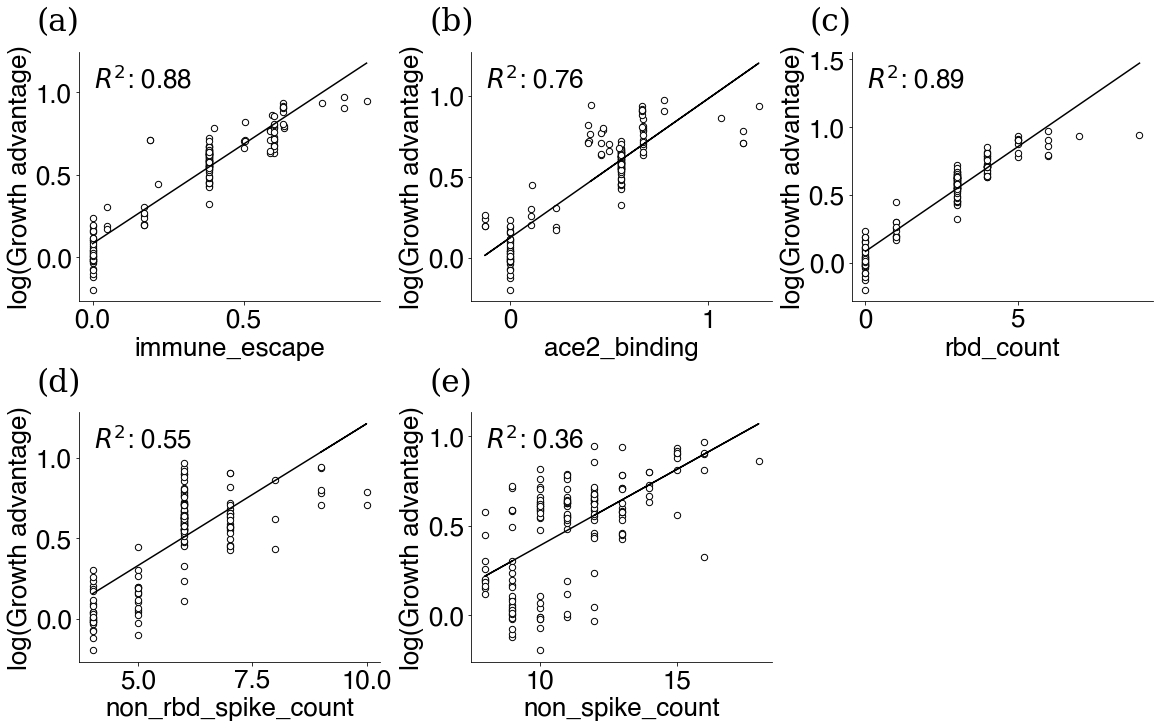

In [18]:
fig = plt.figure(figsize=(16, 10),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=3)

# Defining growth advantage innovation
df = predictors.reset_index().merge(ga_df, how="left")[:-1]
log_ga = np.log(df.median_ga.values)

# Loop over predictor increments and plot
axs = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p]); simple_axis(ax)
    plot_single_regression(ax, 
                          predictor = df[name].values, 
                          outcome = log_ga,
                          xlabel = name,
                          ylabel = "log(Growth advantage)")
    axs.append(ax)
    
# Adding panel labels
labels = [ "(" + letter + ")" for letter in string.ascii_lowercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [19]:
fig.savefig("figures/predictors-growth-advantage.png", facecolor="white")

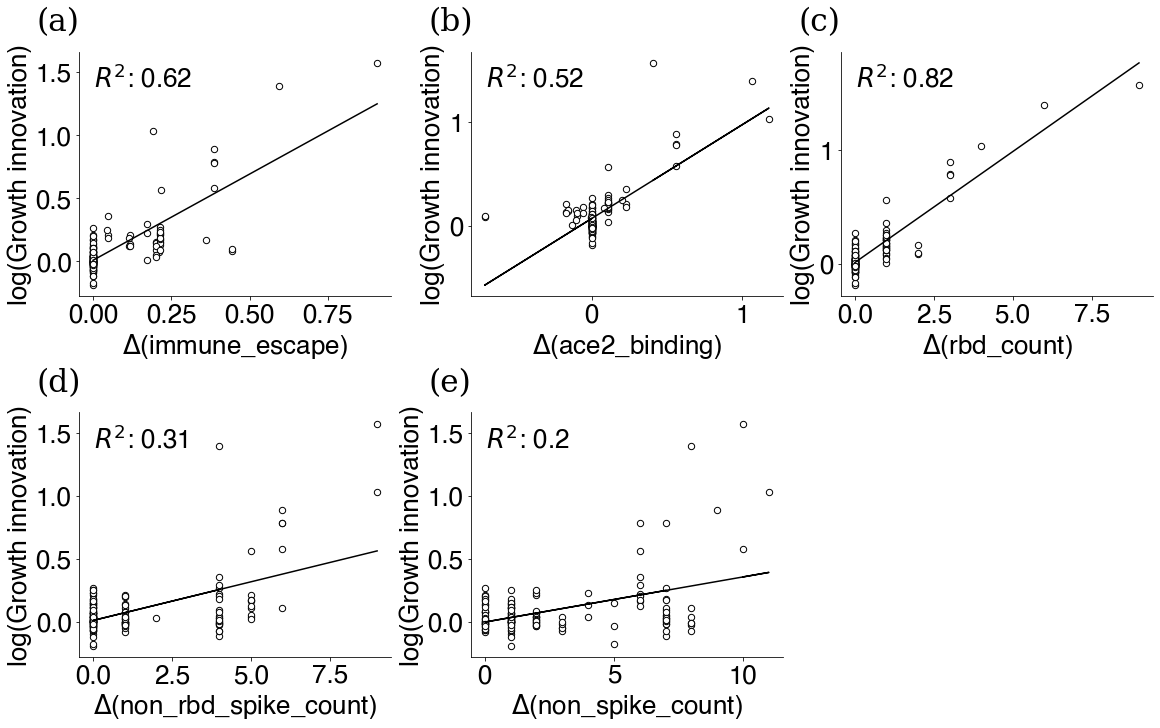

In [20]:
fig = plt.figure(figsize=(16, 10),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=3)

# Defining growth advantage innovation
df = predictors.reset_index().merge(ga_delta_df, how="left")
log_ga_delta = np.log(df.median_ga_delta.values)

# Loop over predictor increments and plot
axs = []
for p, name in enumerate(predictor_names):
    ax = fig.add_subplot(gs[p]); simple_axis(ax)
    plot_single_regression(ax, 
                          predictor = df["delta_"+name].values, 
                          outcome = log_ga_delta,
                          xlabel = rf"$\Delta$({name})",
                          ylabel = "log(Growth innovation)")
    axs.append(ax)
    
# Adding panel labels
labels = [ "(" + letter + ")" for letter in string.ascii_lowercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [21]:
fig.savefig("figures/delta-predictors-growth-advantage-innovation.png", facecolor="white")

In [22]:
def add_multi_regression(ax, raw_x, raw_y, show_r_square=True):   
    
    # Find and remove rows with nans
    is_x_obs = ~np.isnan(raw_x).any(axis=1) 
    x, y = raw_x[is_x_obs, :], raw_y[is_x_obs]
    
    # Define and fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    
    # Generate predictions
    y_pred = model.predict(x)

    # Compute R^2
    r_square = model.score(x, y) 
    if show_r_square:
        ax.text(0.05, 0.95, fr"$R^2$: {r_square.round(2)}", 
                horizontalalignment='left', 
                verticalalignment='top',
                transform=ax.transAxes)
        
    return model, y, y_pred, r_square

def plot_multiple_regression(ax, predictors, outcome, xlabel=None, ylabel=None):
    
    model, y_raw, y_pred, r_square = add_multi_regression(ax, predictors, outcome)
    ax.scatter(y_pred, outcome, ec = "k", color="w", s=40)
    ax.plot(y_pred, y_pred, color="k", linestyle="--")

    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    return model

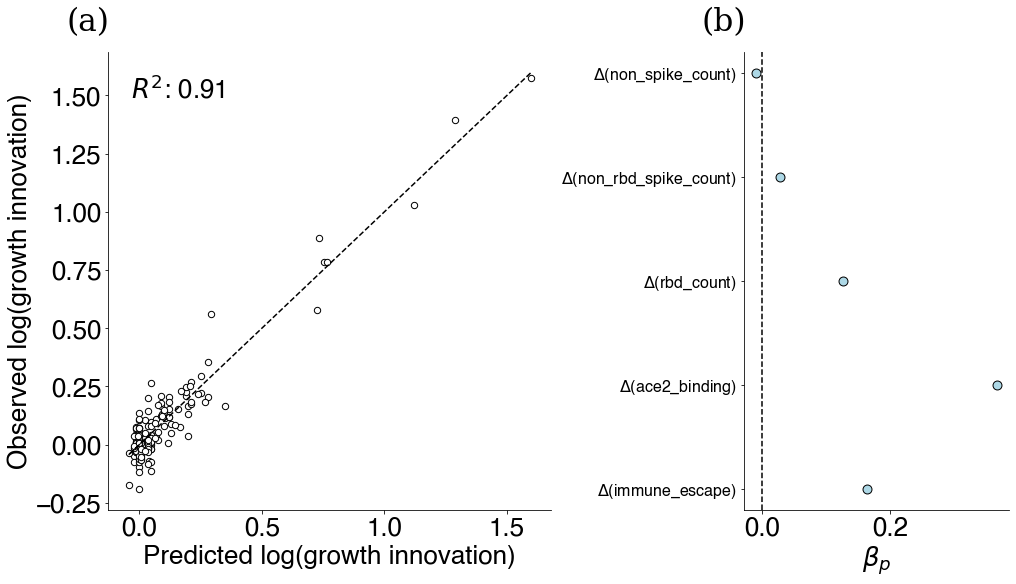

In [23]:
fig = plt.figure(figsize=(14, 8),  constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.0, 0.6])

# Prep predictors and outcome
df = predictors.reset_index().merge(ga_delta_df, how="left")[:-1]
xs = df[["delta_" + name for name in predictor_names]].values
log_ga_delta = np.log(df.median_ga_delta.values)

# Add comparison between observed and predicted
ax_compare = fig.add_subplot(gs[0,0]); simple_axis(ax_compare)
model = plot_multiple_regression(ax_compare, predictors=xs, outcome=log_ga_delta)

## Add diagonal for equality
ax_compare.set_xlabel("Predicted log(growth innovation)")
ax_compare.set_ylabel("Observed log(growth innovation)")


# Show parameter values
ax_betas = fig.add_subplot(gs[0,1]); simple_axis(ax_betas)
betas = model.coef_
ind_betas = np.arange(len(betas))
ax_betas.scatter(betas, ind_betas, ec="k", color="lightblue", s=80)
ax_betas.axvline(0.0, color="k", linestyle="--")
ax_betas.set_yticks(ind_betas)
ax_betas.set_yticklabels([  rf"$\Delta$({name})" for name in predictor_names], size=16)
ax_betas.set_xlabel(r"$\beta_{p}$")

# Adding panel labels
axs = [ax_compare, ax_betas]
labels = [ "(" + letter + ")" for letter in string.ascii_lowercase]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [24]:
fig.savefig("figures/multi-delta-predictors-growth-advantage-innovation.png", facecolor="white")